In [1]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm
from tqdm import notebook, trange

%matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

The basic task is to use the data to identify which groups of people are most responsive to each type of offer, and how best to present each type of offer.

## Exploratory Data Analysis

In [2]:
print(len(portfolio))
print(len(profile))
print(len(transcript))

10
17000
306534


In [3]:
print('portfolio shape is', portfolio.shape)
portfolio

portfolio shape is (10, 6)


,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


In [4]:
print('transcript shape is', transcript.shape)
transcript.sample(9)

transcript shape is (306534, 4)


,person,event,value,time
179327,bfce6d50205a4f6982d87ce80e5d5356,offer completed,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...,432
171475,dd2b1fc955274b558f004a1540baaed1,offer viewed,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},420
105852,2c8adcf84d1643628f893c2084e3d3fd,transaction,{'amount': 2.45},300
275938,080fc5e11b2a4dbeb88e1ffa952cb638,offer viewed,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},606
182080,8bf722542af848079c72dd4cde722d0e,transaction,{'amount': 1.83},438
137065,373993860d4c4f859828acb6ac2c140a,offer viewed,{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'},360
47927,d69b874c0b504bb1b445df034fa874a9,transaction,{'amount': 13.6},132
67537,efb39b7ee83e4c5db10dd629efad5293,transaction,{'amount': 19.52},168
232884,2e87ba0fba1a4d1a8614af771f07a94d,transaction,{'amount': 22.1},540


In [5]:
print('profile shape is', profile.shape)
profile.head()

profile shape is (17000, 5)


,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


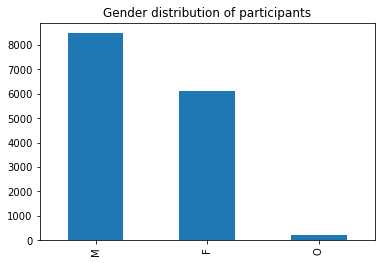

In [6]:

profile.gender.value_counts().plot(kind='bar')
plt.title('Gender distribution of participants');

In [7]:
profile.gender.isna().sum()

2175

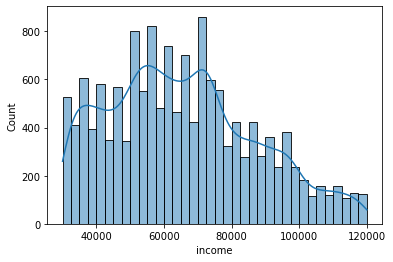

In [8]:
sns.histplot(profile.income, kde=True);

In [9]:
portfolio.describe()

,reward,difficulty,duration
count,10.000000,10.000000,10.000000
mean,4.200000,7.700000,6.500000
std,3.583915,5.831905,2.321398
min,0.000000,0.000000,3.000000
25%,2.000000,5.000000,5.000000
50%,4.000000,8.500000,7.000000
75%,5.000000,10.000000,7.000000
max,10.000000,20.000000,10.000000


In [10]:
profile.describe()

,age,became_member_on,income
count,17000.000000,1.700000e+04,14825.000000
mean,62.531412,2.016703e+07,65404.991568
std,26.738580,1.167750e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,45.000000,2.016053e+07,49000.000000
50%,58.000000,2.017080e+07,64000.000000
75%,73.000000,2.017123e+07,80000.000000
max,118.000000,2.018073e+07,120000.000000


In [11]:
transcript.describe()

,time
count,306534.000000
mean,366.382940
std,200.326314
min,0.000000
25%,186.000000
50%,408.000000
75%,528.000000
max,714.000000


In [12]:
from datetime import datetime

In [13]:
profile['became_member_on'] = profile.became_member_on.astype(str)

In [14]:
# change date column to datetime
profile['became_member_on'] = profile.became_member_on.apply(lambda s: datetime(year=int(s[0:4]), month=int(s[4:6]), day=int(s[6:8])))
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,2018-07-12,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,2017-08-04,NaN


In [15]:
cols = ['web', 'email', 'mobile', 'social']
for col in cols:
    portfolio[col] = portfolio.channels.apply(lambda x: int(col in x))
portfolio

,reward,channels,difficulty,duration,offer_type,id,web,email,mobile,social
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,0,1,1,1
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed,1,1,1,0
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,1,0
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,1,0,0
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,1,1
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,1
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837,0,1,1,1
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,1
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5,1,1,1,0


In [16]:
def to_list(dict_):
    import pandas as pd
    lst = []
    for i,j in dict_.items():
        temp = [i,j]
        lst.extend(temp)
    return pd.Series({'type': lst[0], 'id' : lst[1]})


In [17]:
%%time
transcript.loc[:,['type', 'id']] = transcript.value.apply(to_list)
del transcript['value']
transcript.sample(5)

Wall time: 1min 26s


,person,event,time,type,id
96218,2290f2fb303e46579ecb6d79b0409d0c,transaction,252,amount,17.45
103858,adeaeb917eac4f4ab806e68981a51703,offer viewed,294,offer id,ae264e3637204a6fb9bb56bc8210ddfd
273434,ecce51f5f6224fc7a765988372b52277,offer viewed,600,offer id,fafdcd668e3743c1bb461111dcafc2a4
53865,7fba4434434a4872b4b98d3639a75de3,offer received,168,offer id,fafdcd668e3743c1bb461111dcafc2a4
33697,12279fadfd514607871f8b525780edc4,transaction,60,amount,4.28


In [18]:

amt_spent = transcript[transcript.event == 'transaction'].groupby('person', as_index=False)['id'].sum()
amt_spent.columns = ['person','amount']
print(len(amt_spent))
amt_spent.head()

16578


,person,amount
0,0009655768c64bdeb2e877511632db8f,127.60
1,00116118485d4dfda04fdbaba9a87b5c,4.09
2,0011e0d4e6b944f998e987f904e8c1e5,79.46
3,0020c2b971eb4e9188eac86d93036a77,196.86
4,0020ccbbb6d84e358d3414a3ff76cffd,154.05


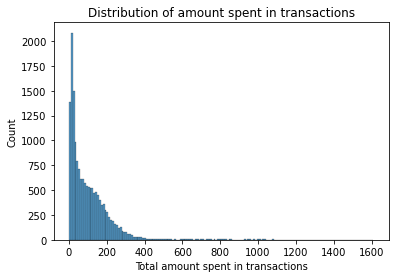

In [19]:
# not everyone in the population made a transaction
sns.histplot(amt_spent.amount)
plt.xlabel('Total amount spent in transactions')
plt.title('Distribution of amount spent in transactions');

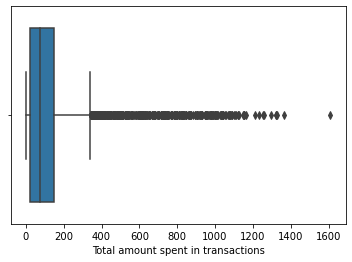

In [20]:
sns.boxplot(x=amt_spent.amount)
plt.xlabel('Total amount spent in transactions');

In [21]:
# most of the participants spent 400 and below over the test period.
# Using a cut-off of 400, see how many of those below and above this threshold view an offer and also complete an offer

In [22]:
del portfolio['channels']
portfolio

,reward,difficulty,duration,offer_type,id,web,email,mobile,social
0,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,0,1,1,1
1,10,10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1
2,0,0,4,informational,3f207df678b143eea3cee63160fa8bed,1,1,1,0
3,5,5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,1,0
4,5,20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,1,0,0
5,3,7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,1,1
6,2,10,10,discount,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,1
7,0,0,3,informational,5a8bc65990b245e5a138643cd4eb9837,0,1,1,1
8,5,5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,1
9,2,10,7,discount,2906b810c7d4411798c6938adc9daaa5,1,1,1,0


In [23]:
portfolio['offer_detail'] = portfolio[portfolio.columns[:4]].apply(lambda x: ''.join(x.astype(str)), axis=1)
portfolio

,reward,difficulty,duration,offer_type,id,web,email,mobile,social,offer_detail
0,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,0,1,1,1,10107bogo
1,10,10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1,10105bogo
2,0,0,4,informational,3f207df678b143eea3cee63160fa8bed,1,1,1,0,004informational
3,5,5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,1,0,557bogo
4,5,20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,1,0,0,52010discount
5,3,7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,1,1,377discount
6,2,10,10,discount,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,1,21010discount
7,0,0,3,informational,5a8bc65990b245e5a138643cd4eb9837,0,1,1,1,003informational
8,5,5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,1,555bogo
9,2,10,7,discount,2906b810c7d4411798c6938adc9daaa5,1,1,1,0,2107discount


In [24]:
profile.rename(columns={'id':'person'}, inplace=True)
profile.head()

,gender,age,person,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,2018-07-12,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,2017-08-04,NaN


In [25]:
portfolio_less_info = portfolio[portfolio.offer_type != 'informational']
final_data = transcript.merge(portfolio_less_info, on='id', how='left')

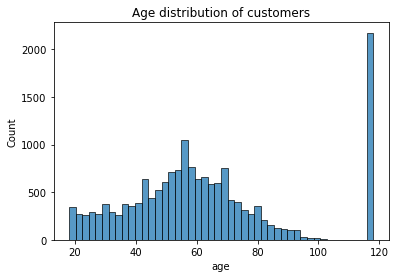

In [26]:
# remove outliers and check if model gets better for it
sns.histplot(profile.age)
plt.title('Age distribution of customers');

In [27]:
outliers = profile[profile.age > 105]
print(len(outliers))
outliers.sample(5)

2175


,gender,age,person,became_member_on,income
8061,None,118,c9ca9319c2fb451e998ad6325bcac419,2017-10-07,NaN
16839,None,118,d6063a30185b4e60b58a445bacec5f56,2018-06-26,NaN
6756,None,118,e06ce8ddf1c24f588a96bb269bb2601e,2017-11-17,NaN
1218,None,118,d558b038136e4474a94ac2bb0a67efc9,2015-11-26,NaN
5417,None,118,d72b53c63ec747f281c16c1b3f536d72,2017-10-14,NaN


In [28]:
transcript[transcript.person.isin(outliers.person)].event.value_counts()/transcript[transcript.person.isin(outliers.person)].shape[0]

transaction        0.444036
offer received     0.289471
offer viewed       0.232885
offer completed    0.033608
Name: event, dtype: float64

In [29]:
transcript[~transcript.person.isin(outliers.person)].event.value_counts()/transcript[~transcript.person.isin(outliers.person)].shape[0]

transaction        0.454451
offer received     0.243806
offer viewed       0.182797
offer completed    0.118946
Name: event, dtype: float64

In [30]:
def grp_stat(df):
    """
    returns % of offer viewed and offer completed out of the total offers received.
    
    """
    stat =df.event.value_counts()
    try:
        offer_viewed = round(stat['offer viewed']/stat['offer received'], 2)
    except KeyError:
        offer_viewed = 0
    try:
        offer_completed = round(stat['offer completed']/stat['offer received'], 2)
    except KeyError:
        offer_completed = 0
    return pd.Series({'viewed_perc': offer_viewed,
                     'completed_perc': offer_completed})

In [31]:
print(len(final_data))
offer_stat = final_data.groupby(['person','offer_detail'],as_index=False).apply(grp_stat)
print(len(offer_stat))
offer_stat.head()

306534
50637


,person,offer_detail,viewed_perc,completed_perc
0,0009655768c64bdeb2e877511632db8f,21010discount,1.0,1.0
1,0009655768c64bdeb2e877511632db8f,2107discount,0.0,1.0
2,0009655768c64bdeb2e877511632db8f,555bogo,1.0,1.0
3,00116118485d4dfda04fdbaba9a87b5c,555bogo,1.0,0.0
4,0011e0d4e6b944f998e987f904e8c1e5,377discount,1.0,1.0


In [32]:
offer_stats = offer_stat.merge(amt_spent, on = 'person', how = 'left')
offer_stats['amount_bin'] = np.where(offer_stats.amount > 400, 'above_400', 'below_400')
offer_stats.isna().sum()

person               0
offer_detail         0
viewed_perc          0
completed_perc       0
amount            1271
amount_bin           0
dtype: int64

In [34]:
offer_stats_grp = offer_stats.dropna(subset=['amount']).groupby([ 'offer_detail','amount_bin'], as_index=False).agg({'viewed_perc':'mean','completed_perc':'mean'})
offer_stats_grp

,offer_detail,amount_bin,viewed_perc,completed_perc
0,10105bogo,above_400,0.974074,0.874074
1,10105bogo,below_400,0.960657,0.438303
2,10107bogo,above_400,0.877727,0.910714
3,10107bogo,below_400,0.879822,0.481969
4,21010discount,above_400,0.981595,0.978528
5,21010discount,below_400,0.964924,0.709810
6,2107discount,above_400,0.715564,0.909774
7,2107discount,below_400,0.531717,0.534725
8,377discount,above_400,0.954130,0.927536
9,377discount,below_400,0.960470,0.686808


Offers with the highest difficulty have the lowest completion rate even when they have a high view rate.

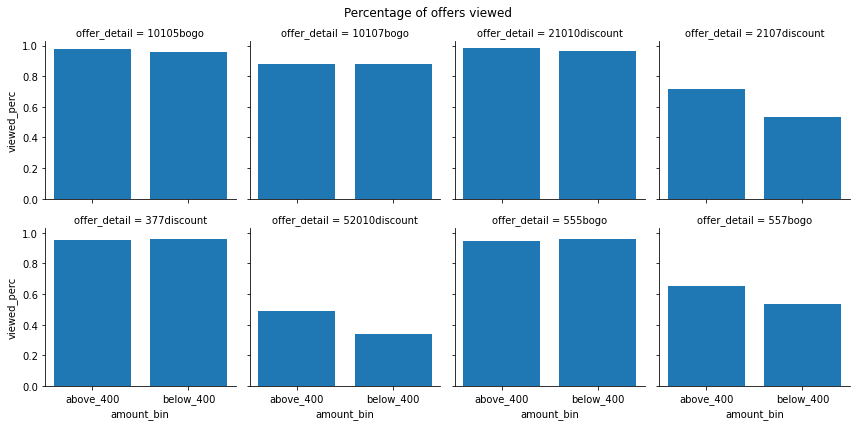

In [35]:
g = sns.FacetGrid(offer_stats_grp, col="offer_detail", col_wrap=4)
g.map_dataframe(plt.bar,'amount_bin',"viewed_perc")
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle('Percentage of offers viewed');

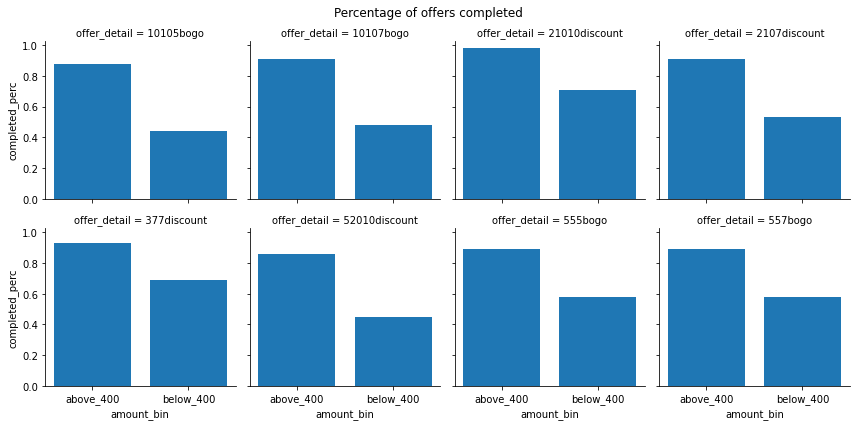

In [36]:
g = sns.FacetGrid(offer_stats_grp, col="offer_detail", col_wrap=4)
g.map_dataframe(plt.bar,'amount_bin',"completed_perc")
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle('Percentage of offers completed');

The largest disparity in completion is at 10105,10107 and 52010. These are the offers with the highest difficulty level.

In [37]:
amt_spent.head()

,person,amount
0,0009655768c64bdeb2e877511632db8f,127.60
1,00116118485d4dfda04fdbaba9a87b5c,4.09
2,0011e0d4e6b944f998e987f904e8c1e5,79.46
3,0020c2b971eb4e9188eac86d93036a77,196.86
4,0020ccbbb6d84e358d3414a3ff76cffd,154.05


In [38]:
profile.head()

,gender,age,person,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,2018-07-12,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,2017-08-04,NaN


In [41]:
amt_income = profile.dropna(subset=['income']).merge(amt_spent.dropna(subset=['amount']), left_on='person', right_on='person', how='inner')
print(len(amt_income))
amt_income.head()

14492


,gender,age,person,became_member_on,income,amount
0,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,77.01
1,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,159.27
2,M,68,e2127556f4f64592b11af22de27a7932,2018-04-26,70000.0,57.73
3,M,65,389bc3fa690240e798340f5a15918d5c,2018-02-09,53000.0,36.43
4,M,58,2eeac8d8feae4a8cad5a6af0499a211d,2017-11-11,51000.0,15.62


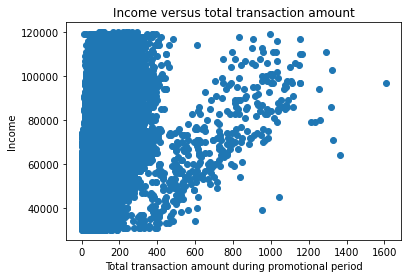

In [42]:
plt.scatter(x=amt_income.amount, y=amt_income.income)
plt.xlabel('Total transaction amount during promotional period')
plt.ylabel('Income')
plt.title('Income versus total transaction amount');

Up until a total spend of 400, it is equally likely for every participant to spend between 0 and 400 regardless of their income. However, total money spent linearly increases with income beyond a total transaction amount of 400.

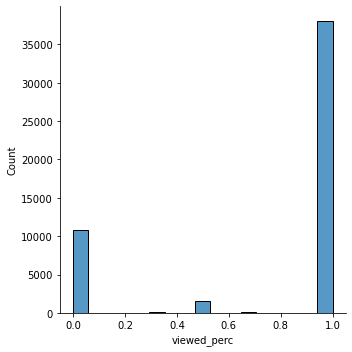

In [43]:
sns.displot(offer_stat.viewed_perc)

In [44]:
def bin_data(x,name):
    if x == 0:
        return 'low_{}'.format(name)
    elif x == 1:
        return 'high_{}'.format(name)
    else:
        return 'mid_{}'.format(name)

In [45]:
offer_stat['view'] = offer_stat.viewed_perc.apply(lambda x: bin_data(x,name='view'))
offer_stat.sample(10)

,person,offer_detail,viewed_perc,completed_perc,view
8326,2be082235f73404caabf535d3f44a1a3,557bogo,1.0,1.0,high_view
44518,e0570660882b49db860b43f704e5590b,21010discount,1.0,1.0,high_view
12828,40ca4949bc5d4567b2521ce9a1ddd6e8,52010discount,0.0,1.0,low_view
44513,e05529cf200549b2aa682eedd994d5f7,557bogo,0.5,1.0,mid_view
5278,1bc9c50db8e849e78f6491bda9e9f7cb,21010discount,1.0,1.0,high_view
26604,86343006f3564aea8ea69f036a3d69b5,555bogo,1.0,0.0,high_view
33345,a6786827eeb44ccfb2e5907382f8cb31,10105bogo,1.0,1.0,high_view
46818,ec22d5bea1034ad3b1ca8bca706ed4e3,377discount,1.0,1.0,high_view
39448,c6a5dadb37e54116a011cff0a1ac1e34,557bogo,0.0,0.0,low_view
11322,39d20ed2014a4631812f12548621e5bb,52010discount,0.5,1.0,mid_view


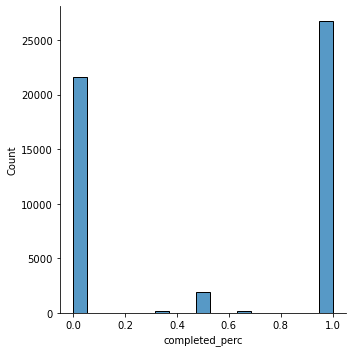

In [46]:
sns.displot(offer_stat.completed_perc)

In [47]:
offer_stat['complete'] = offer_stat.completed_perc.apply(lambda x: bin_data(x,name='complete'))
offer_stat.sample(5)

,person,offer_detail,viewed_perc,completed_perc,view,complete
6137,207333c76c074708b82abdea3883e76e,52010discount,0.0,0.0,low_view,low_complete
17590,5956a3014010475fb534b5939fd1c0ff,557bogo,1.0,1.0,high_view,high_complete
20295,66b825b7056f4d369db6a31d0d2fcf4c,377discount,1.0,1.0,high_view,high_complete
15151,4c96ee37b5bb4d389177ca83222d5d84,2107discount,0.0,0.0,low_view,low_complete
8677,2d36cda33cb8495a9ce38c0dc53d64eb,2107discount,1.0,0.5,high_view,mid_complete


In [48]:
offer_stat.groupby(['view','complete'], as_index=False).agg({'person':'count', 'offer_detail': [lambda x: x.value_counts().index[0],lambda x: x.value_counts()[0]]})

view       complete person   offer_detail           
                             count     <lambda_0> <lambda_1>
0  high_view  high_complete  21835  21010discount       4178
1  high_view   low_complete  14829      10105bogo       3253
2  high_view   mid_complete   1384        555bogo        318
3   low_view  high_complete   4206  52010discount       1376
4   low_view   low_complete   6275  52010discount       2468
5   low_view   mid_complete    330  52010discount        130
6   mid_view  high_complete    711        557bogo        180
7   mid_view   low_complete    537   2107discount        123
8   mid_view   mid_complete    530        557bogo        146

In [49]:
all_data = offer_stat.merge(profile, on = 'person', how = 'left')
print(len(all_data))
all_data.head()

50637


,person,offer_detail,viewed_perc,completed_perc,view,complete,gender,age,became_member_on,income
0,0009655768c64bdeb2e877511632db8f,21010discount,1.0,1.0,high_view,high_complete,M,33,2017-04-21,72000.0
1,0009655768c64bdeb2e877511632db8f,2107discount,0.0,1.0,low_view,high_complete,M,33,2017-04-21,72000.0
2,0009655768c64bdeb2e877511632db8f,555bogo,1.0,1.0,high_view,high_complete,M,33,2017-04-21,72000.0
3,00116118485d4dfda04fdbaba9a87b5c,555bogo,1.0,0.0,high_view,low_complete,None,118,2018-04-25,NaN
4,0011e0d4e6b944f998e987f904e8c1e5,377discount,1.0,1.0,high_view,high_complete,O,40,2018-01-09,57000.0


age and income distribution facet by view and complete

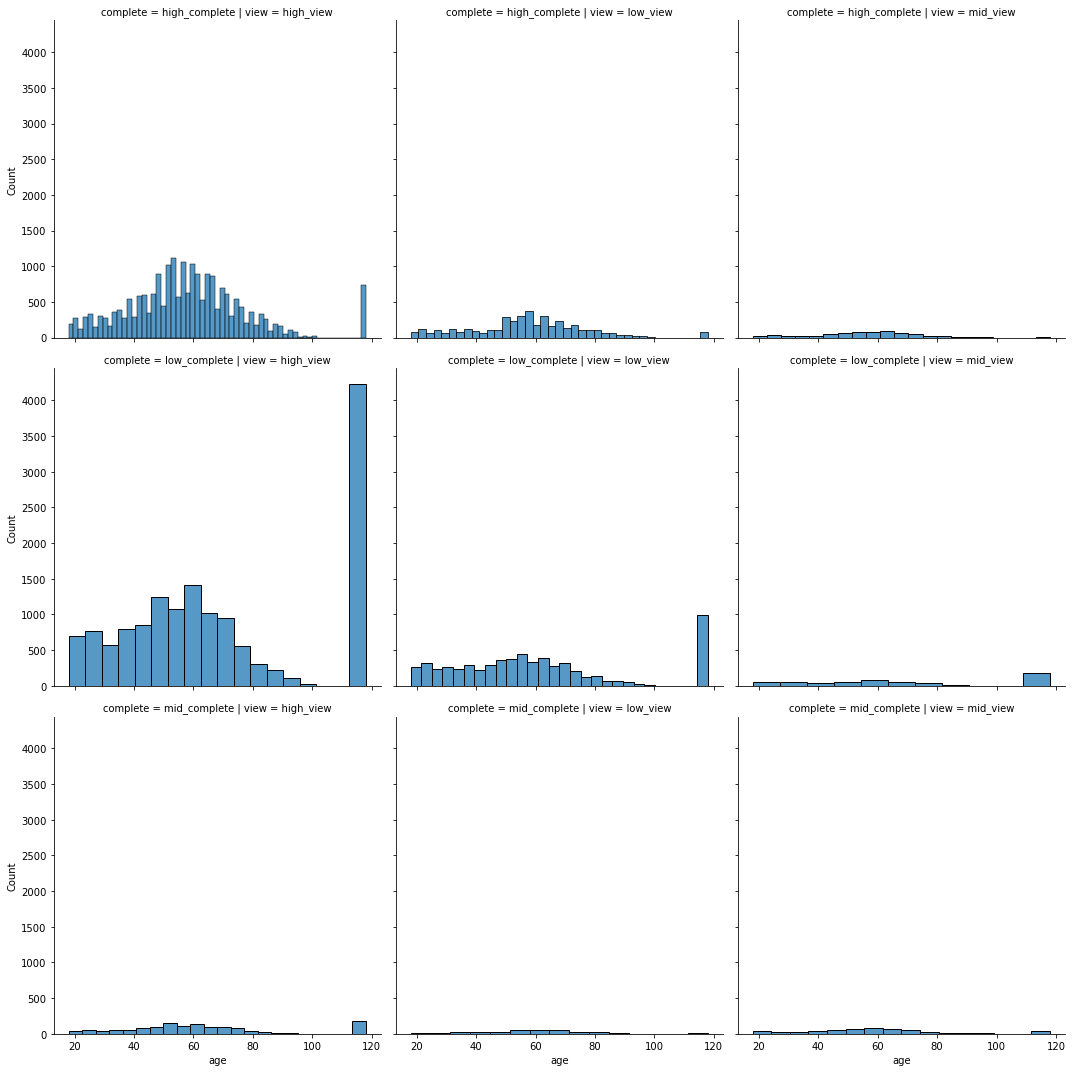

In [50]:
g = sns.FacetGrid(all_data, col="view",  row="complete", height=5)
g.map_dataframe(sns.histplot, x="age");

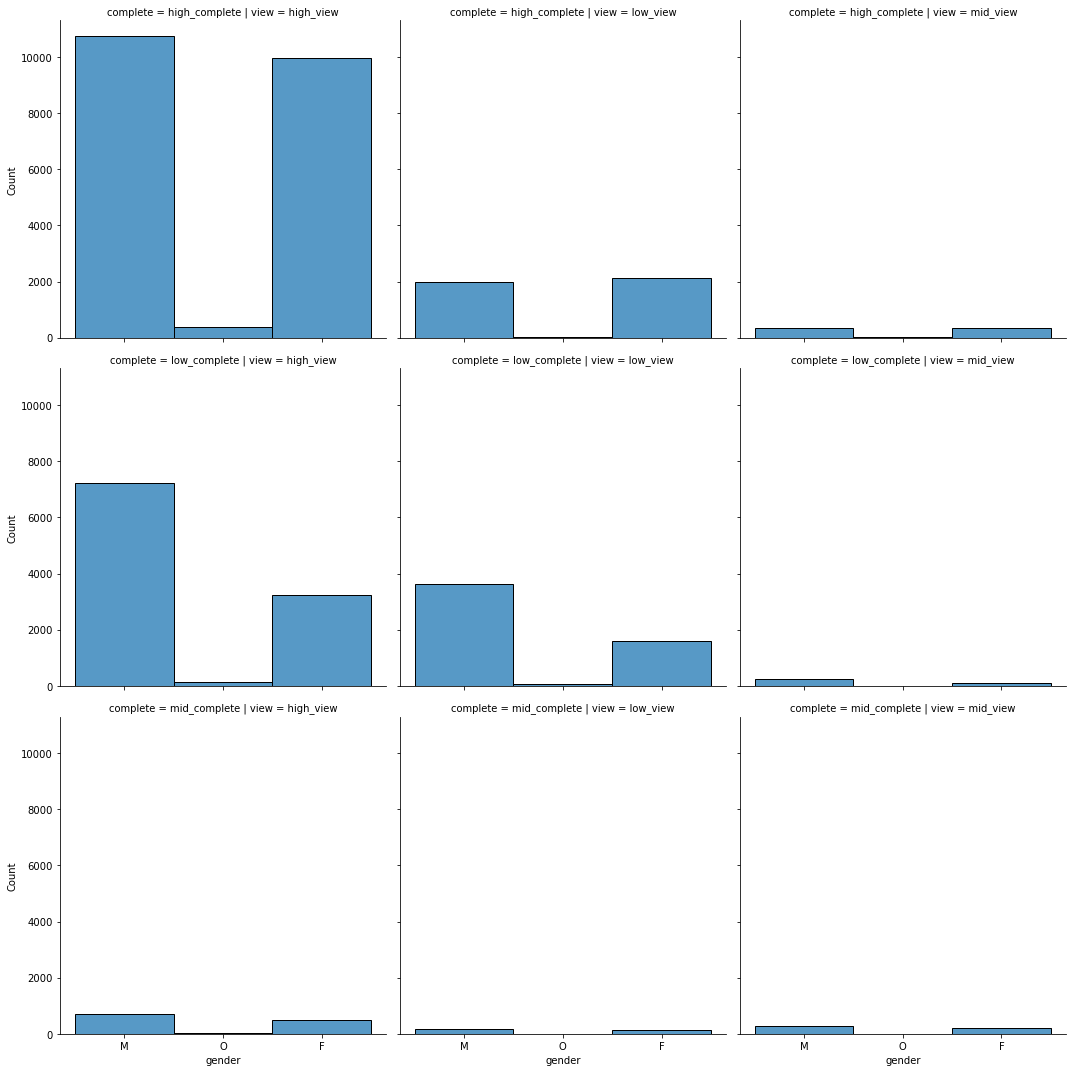

In [51]:
g = sns.FacetGrid(all_data, col="view",  row="complete", height=5)
g.map_dataframe(sns.histplot, x="gender");

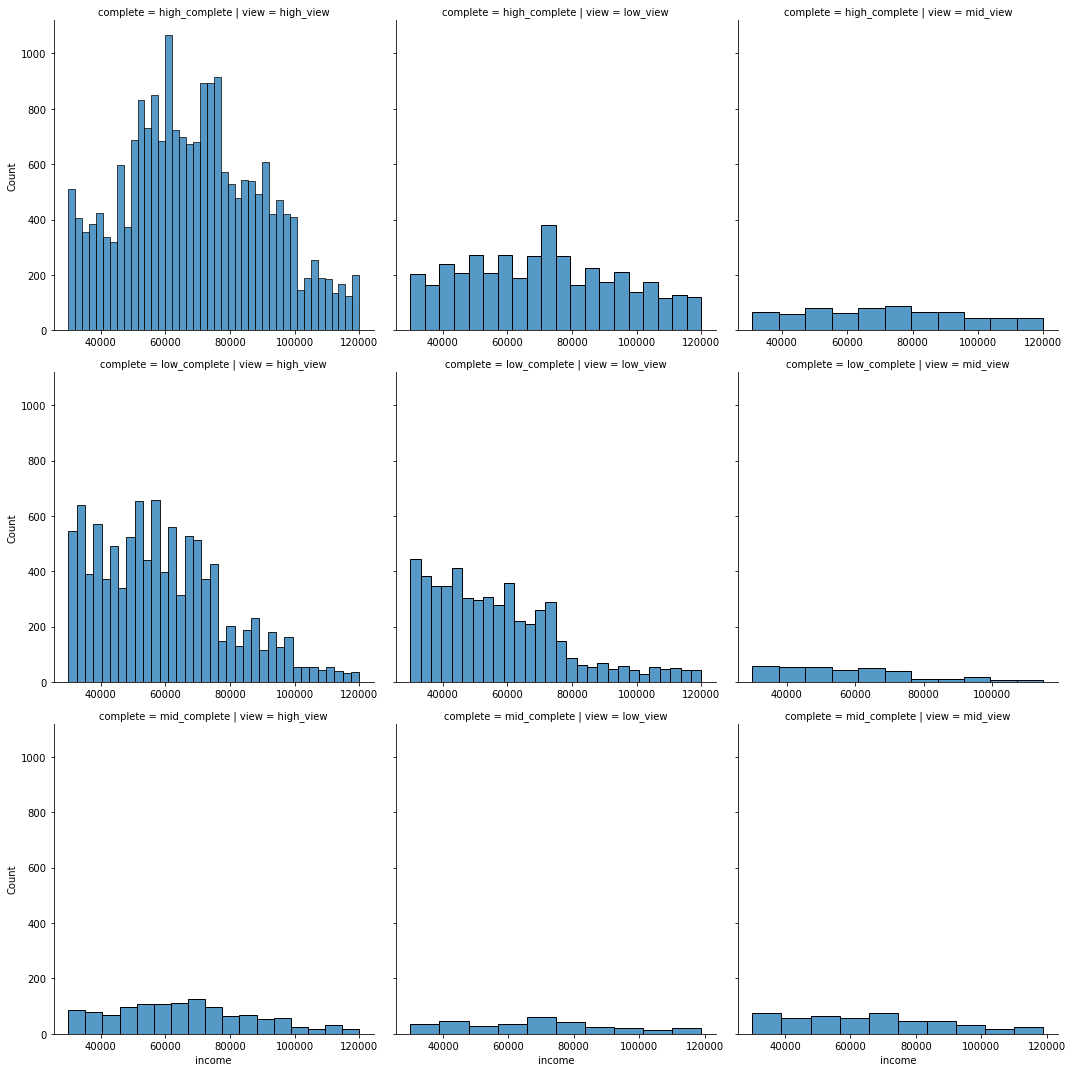

In [52]:
g = sns.FacetGrid(all_data, col="view",  row="complete", height=5, sharex=False)
g.map_dataframe(sns.histplot, x="income");

In [53]:
offer_stat.completed_perc.value_counts()

1.00    26752
0.00    21641
0.50     1921
0.67      154
0.33      152
0.75        9
0.25        5
0.60        1
0.20        1
0.40        1
Name: completed_perc, dtype: int64

In [54]:
offer_stat.viewed_perc.value_counts()

1.00    38048
0.00    10811
0.50     1524
0.67      138
0.33      104
0.75        7
0.25        4
0.20        1
Name: viewed_perc, dtype: int64

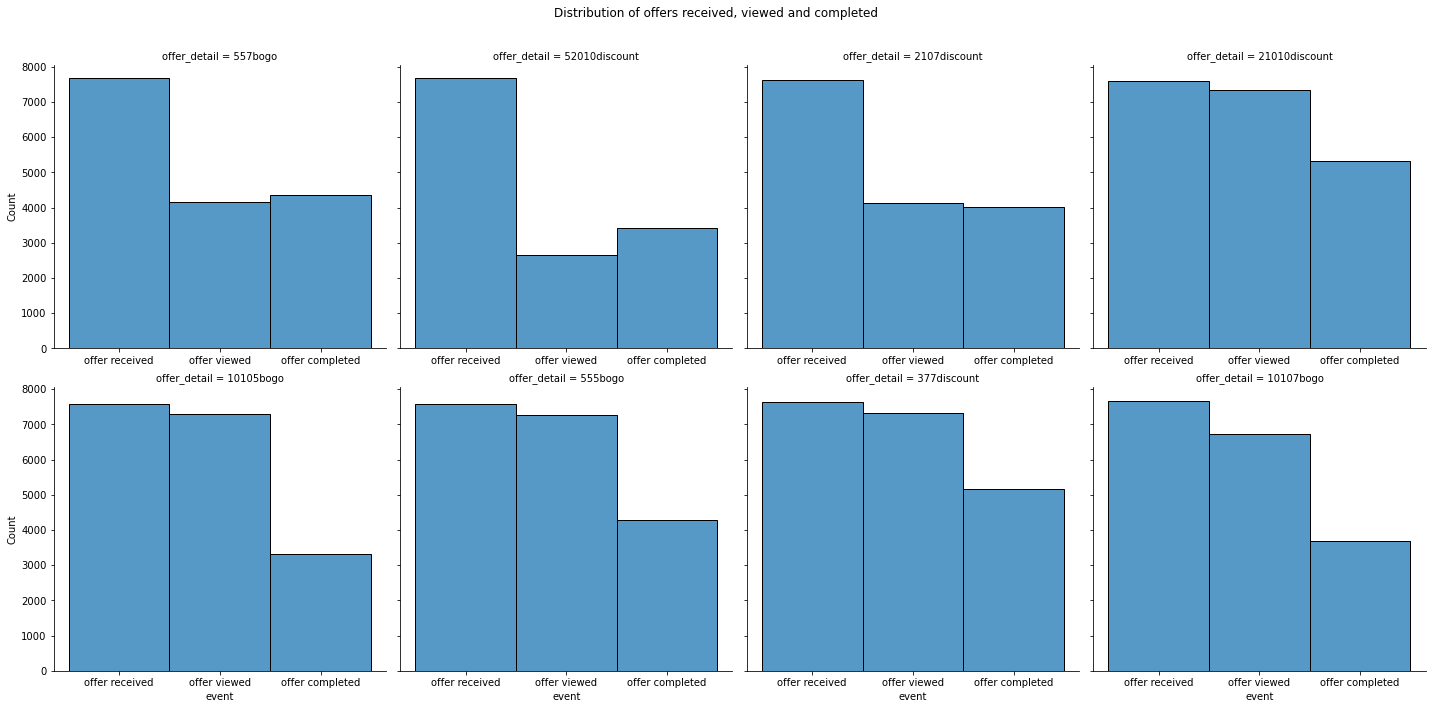

In [55]:
g = sns.FacetGrid(final_data, col="offer_detail", height=5, sharex=False, col_wrap=4)
g.map_dataframe(sns.histplot, x="event")
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle('Distribution of offers received, viewed and completed');

only 2 were completed more than viewed

## Modeling

In [56]:
final_data.head()

,person,event,time,type,id,reward,difficulty,duration,offer_type,web,email,mobile,social,offer_detail
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,offer id,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.0,5.0,7.0,bogo,1.0,1.0,1.0,0.0,557bogo
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,offer id,0b1e1539f2cc45b7b9fa7c272da2e1d7,5.0,20.0,10.0,discount,1.0,1.0,0.0,0.0,52010discount
2,e2127556f4f64592b11af22de27a7932,offer received,0,offer id,2906b810c7d4411798c6938adc9daaa5,2.0,10.0,7.0,discount,1.0,1.0,1.0,0.0,2107discount
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,offer id,fafdcd668e3743c1bb461111dcafc2a4,2.0,10.0,10.0,discount,1.0,1.0,1.0,1.0,21010discount
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,offer id,4d5c57ea9a6940dd891ad53e9dbe8da0,10.0,10.0,5.0,bogo,1.0,1.0,1.0,1.0,10105bogo


In [57]:
#final_data = final_data[~final_data.id.isin(['3f207df678b143eea3cee63160fa8bed','5a8bc65990b245e5a138643cd4eb9837'])]

idx = round(0.85 * len(final_data))
data = final_data[['person', 'event', 'offer_detail']]
train_data = data.iloc[:idx,]
test_data = data.iloc[idx:,]

train_data_df = train_data.groupby(['person','offer_detail'], as_index=False).agg({'event': lambda x: sum(x=='offer completed')})
test_data_df = test_data.groupby(['person','offer_detail'], as_index=False).agg({'event': lambda x: sum(x=='offer completed')})


In [58]:
person_offer_df = train_data_df.groupby(['person','offer_detail'])['event'].max().astype(bool).astype(int).unstack()
person_offer_df_test = test_data_df.groupby(['person','offer_detail'])['event'].max().astype(bool).astype(int).unstack()

person_offer_df.head()

offer_detail,10105bogo,10107bogo,21010discount,2107discount,377discount,52010discount,555bogo,557bogo
person,,,,,,,,
0009655768c64bdeb2e877511632db8f,NaN,NaN,1.0,1.0,NaN,NaN,1.0,NaN
00116118485d4dfda04fdbaba9a87b5c,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
0011e0d4e6b944f998e987f904e8c1e5,NaN,NaN,NaN,NaN,1.0,1.0,NaN,1.0
0020c2b971eb4e9188eac86d93036a77,1.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN
0020ccbbb6d84e358d3414a3ff76cffd,NaN,NaN,NaN,NaN,1.0,NaN,1.0,0.0


In [59]:
person_offer_mat = person_offer_df.values
person_offer_mat_test = person_offer_df_test.values

In [62]:
def FunkSVD(ratings_mat, latent_features=4, learning_rate=0.0001, iters=100):
    '''
    This function performs matrix factorization using a basic form of FunkSVD with no regularization
    
    INPUT:
    ratings_mat - (numpy array) a matrix with users as rows, movies as columns, and ratings as values
    latent_features - (int) the number of latent features used
    learning_rate - (float) the learning rate 
    iters - (int) the number of iterations
    
    OUTPUT:
    user_mat - (numpy array) a user by latent feature matrix
    movie_mat - (numpy array) a latent feature by movie matrix
    '''
    
    # Set up useful values to be used through the rest of the function
    n_users = ratings_mat.shape[0] # number of rows in the matrix
    n_movies = ratings_mat.shape[1] # number of movies in the matrix
    num_ratings = n_users * n_movies # total number of ratings in the matrix
    
    # initialize the user and movie matrices with random values
    # helpful link: https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.rand.html
    user_mat = np.random.rand(n_users,latent_features) # user matrix filled with random values of shape user x latent 
    movie_mat = np.random.rand(latent_features, n_movies) # movie matrix filled with random values of shape latent x movies
    
    # initialize sse at 0 for first iteration
    sse_accum = 0
    
    # header for running results
    print("Optimization Statistics")
    print("Iterations | Mean Squared Error ")
    
    # for each iteration
    for i in notebook.trange(iters):
        # update our sse
        old_sse = sse_accum
        sse_accum = 0
        
        # For each user-movie pair
        for j in range(num_ratings):
            row = j//n_movies
            col = j%n_movies
                # if the rating exists
            if not np.isnan(ratings_mat[row,col]): 
                    # compute the error as the actual minus the dot product of the user and movie latent features
                error = ratings_mat[row,col] - np.dot(user_mat[row,:], movie_mat[:,col])
                    # Keep track of the total sum of squared errors for the matrix
                sse_accum += error**2
                    # update the values in each matrix in the direction of the gradient
                for k in range(latent_features):
                    user_mat[row,k] += 2*learning_rate*movie_mat[k,col]*error
                    movie_mat[k,col] += 2*learning_rate*user_mat[row,k]*error # try and update movie_mat after all user_mat is updated and see if it changes anything
        # print results for iteration
        if i%300 == 0:
            print(i, '|', sse_accum)
        if i == 3000:
            learning_rate = learning_rate*2
    return user_mat, movie_mat 

In [63]:
# This takes about 1hr to complete the iterations. iters may be reduced for faster execution
person_mat, offer_mat = FunkSVD(person_offer_mat, latent_features=15, learning_rate=0.001, iters=3000)

Optimization Statistics
Iterations | Mean Squared Error 


  0%|          | 0/3000 [00:00<?, ?it/s]

0 | 19834.780897852663
300 | 10139.660307758153
600 | 4216.556746054463
900 | 1335.8166098510817
1200 | 314.4825064805757
1500 | 70.5591023459447
1800 | 16.93033008641718
2100 | 4.704368402284338
2400 | 1.6602535295799155
2700 | 0.7970681292069791


  0%|          | 0/13 [00:00<?, ?it/s]

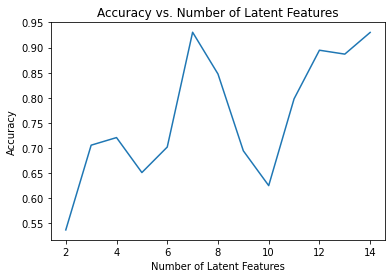

In [64]:
num_latent_feats = np.arange(2,15,1)
sum_errs = []

for i in notebook.trange(len(num_latent_feats)):
    k = num_latent_feats[i]
    # restructure with k latent features
    u_new, vt_new = person_mat[:, :k], offer_mat[:k, :]
    
    # take dot product
    person_offer_est = np.around(np.dot(u_new, vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.nansum(np.subtract(person_offer_mat, person_offer_est))
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
n_notna = (~np.isnan(person_offer_mat)).sum()
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/(n_notna));
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

### When 0 is in the test set

In [65]:
person_offer_df.sample(5)

offer_detail,10105bogo,10107bogo,21010discount,2107discount,377discount,52010discount,555bogo,557bogo
person,,,,,,,,
c58726d95ba8447ba01036e9d50da94c,NaN,NaN,1.0,NaN,1.0,NaN,NaN,0.0
7ffbb6f34b834970966214e754b5a35a,0.0,0.0,NaN,0.0,NaN,NaN,NaN,NaN
b6414121421d43b5b45cdd70f1f1c8d1,0.0,NaN,NaN,NaN,1.0,0.0,0.0,NaN
b367b8304c07429986bc390d4d24c320,NaN,0.0,0.0,NaN,0.0,NaN,0.0,0.0
2c6d717ac83a44e3bdac1a09b2c1b3a7,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [66]:
person_offer_df_test[person_offer_df_test.index == '42e511d82add46d4b0038ab71015f1b5']

offer_detail,10105bogo,10107bogo,21010discount,2107discount,377discount,52010discount,555bogo,557bogo
person,,,,,,,,
42e511d82add46d4b0038ab71015f1b5,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN


In [67]:
row = np.where(person_offer_df.index=='42e511d82add46d4b0038ab71015f1b5')[0][0]
np.around(np.dot(person_mat[row, :7], offer_mat[:7,])).astype(bool).astype(int)

array([0, 1, 1, 0, 0, 1, 1, 1])

The occurrence of 0 for an offer in the test set always force the prediction to zero in the test set. This makes sense because the algorithm tries to reproduce the observed values in the training examples while imputing the missing values. However, this affects the actual prediction on the test set because the fact that a customer did not complete an offer in the past does not mean such will not complete the same offer in the future.

  0%|          | 0/13 [00:00<?, ?it/s]

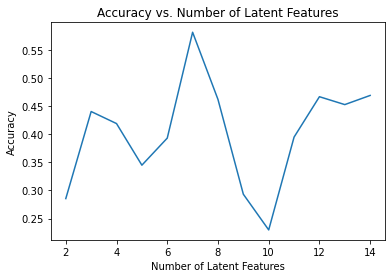

In [68]:
subset_test = person_offer_df_test[person_offer_df_test.index.isin(person_offer_df.index)]

row_idx = np.where(person_offer_df.index.isin(subset_test.index))[0]

n = len(row_idx) # no of users in test that can be predicted from train

num_latent_feats = np.arange(2,15,1)
sum_errs = []

for i in notebook.trange(len(num_latent_feats)):
    k = num_latent_feats[i]
    # restructure with k latent features
    u_new, vt_new = person_mat[row_idx, :k], offer_mat[:k, :]
    
    # take dot product
    person_offer_est = np.around(np.dot(u_new, vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.nansum(np.subtract(subset_test.values, person_offer_est))
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
n_notna = (~np.isnan(subset_test.values)).sum()
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/(n_notna));
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

In [69]:
k=10
sse_naive = 0
sse = 0
acc = []
acc_naive = []
person_list = np.intersect1d(person_offer_df_test.index,person_offer_df.index)

for i in notebook.trange(len(person_list)):
    person = person_list[i]
    row = np.where(person_offer_df.index == person)[0][0]
    pred = np.around(np.dot(person_mat[row,:k], offer_mat[:k,])).astype(bool).astype(int)
    pred_naive = 0
    actual = person_offer_df_test.loc[person].values
    error = actual-pred
    error_naive = actual - pred_naive
    
    sse += np.nansum(error**2)
    acc.append(np.nansum(np.abs(error)))
    
    acc_naive.append(np.nansum(np.abs(error_naive)))
    sse_naive += np.nansum(error_naive**2)
    
n_notna = (~np.isnan(person_offer_mat_test)).sum()
mse1 = sse/n_notna
accur1 = 1- sum(acc)/n_notna
mse_naive1 = sse_naive/n_notna
accur_naive1 = 1- sum(acc_naive)/n_notna
print('mse', mse1,'accuracy', accur1)
print('mse_naive', mse_naive1, 'accuracy naive', accur_naive1)

  0%|          | 0/9312 [00:00<?, ?it/s]

mse 0.5675803850896329 accuracy 0.43241961491036707
mse_naive 0.6852888172246988 accuracy naive 0.3147111827753012


### No cold start problem

In [70]:
len(np.intersect1d(person_offer_df_test.index,person_offer_df.index)) == len(person_offer_df_test)

True

### Replacing 0s with np.nan prior to modeling

In [71]:
personOffer_df = train_data_df.groupby(['person','offer_detail'])['event'].max().astype(bool).astype(int).unstack().replace(0,np.nan)
personOffer_df_test = test_data_df.groupby(['person','offer_detail'])['event'].max().astype(bool).astype(int).unstack()

personOffer_df.head()

offer_detail,10105bogo,10107bogo,21010discount,2107discount,377discount,52010discount,555bogo,557bogo
person,,,,,,,,
0009655768c64bdeb2e877511632db8f,NaN,NaN,1.0,1.0,NaN,NaN,1.0,NaN
00116118485d4dfda04fdbaba9a87b5c,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0011e0d4e6b944f998e987f904e8c1e5,NaN,NaN,NaN,NaN,1.0,1.0,NaN,1.0
0020c2b971eb4e9188eac86d93036a77,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN
0020ccbbb6d84e358d3414a3ff76cffd,NaN,NaN,NaN,NaN,1.0,NaN,1.0,NaN


In [72]:
personOffer_mat = personOffer_df.values
personMat, offerMat = FunkSVD(personOffer_mat, latent_features=15, learning_rate=0.001, iters=1000)

Optimization Statistics
Iterations | Mean Squared Error 


  0%|          | 0/1000 [00:00<?, ?it/s]

0 | 7090.802897171408
300 | 254.9620632905097
600 | 136.04802888251464
900 | 77.88249200476044


  0%|          | 0/13 [00:00<?, ?it/s]

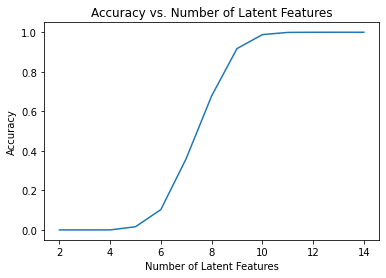

In [73]:
num_latent_feats = np.arange(2,15,1)
sum_errs = []

for i in notebook.trange(len(num_latent_feats)):
    k = num_latent_feats[i]
    # restructure with k latent features
    u_new, vt_new = personMat[:, :k], offerMat[:k, :]
    
    # take dot product
    person_offer_est = np.around(np.dot(u_new, vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.nansum(np.subtract(personOffer_mat, person_offer_est))
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
n_notna = (~np.isnan(personOffer_mat)).sum()
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/(n_notna));
plt.xlabel('Number of Latent Features')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Number of Latent Features');

  0%|          | 0/13 [00:00<?, ?it/s]

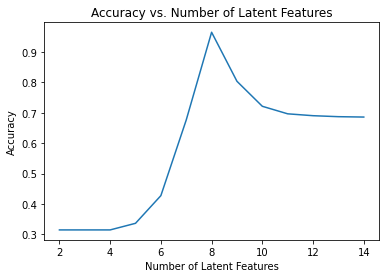

In [74]:
subset_test = personOffer_df_test[personOffer_df_test.index.isin(personOffer_df.index)]

row_idx = np.where(personOffer_df.index.isin(subset_test.index))[0]
#col_idx = np.where(person_offer_df.columns.isin(subset_test.columns))[0]

n = len(row_idx) # no of users in test that can be predicted from train
#m = len(col_idx) # no of features in test that can be predicted from train

num_latent_feats = np.arange(2,15,1)
sum_errs = []

for i in notebook.trange(len(num_latent_feats)):
    k = num_latent_feats[i]
    # restructure with k latent features
    u_new, vt_new = personMat[row_idx, :k], offerMat[:k, :]
    
    # take dot product
    person_offer_est = np.around(np.dot(u_new, vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.nansum(np.subtract(subset_test.values, person_offer_est))
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
n_notna = (~np.isnan(subset_test.values)).sum()
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/(n_notna));
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

In [75]:
k=9
sse_naive = 0
sse = 0
acc = []
acc_naive = []
person_list = np.intersect1d(personOffer_df_test.index,personOffer_df.index)

for i in notebook.trange(len(person_list)):
    person = person_list[i]
    row = np.where(personOffer_df.index == person)[0][0]
    pred = np.dot(personMat[row,:k], offerMat[:k,]).astype(bool).astype(int)
    pred_naive = 0
    actual = personOffer_df_test.loc[person].values
    error = actual-pred
    error_naive = actual - pred_naive
    
    sse += np.nansum(error**2)
    acc.append(np.nansum(np.abs(error)))
    
    acc_naive.append(np.nansum(np.abs(error_naive)))
    sse_naive += np.nansum(error_naive**2)
    
n_notna = (~np.isnan(personOffer_df_test.values)).sum()
mse2 = sse/n_notna
accur2 = 1- sum(acc)/n_notna
mse_naive2 = sse_naive/n_notna
accur_naive2 = 1- sum(acc_naive)/n_notna
print('mse', mse2,'accuracy', accur2)
print('mse_naive', mse_naive2, 'accuracy naive', accur_naive2)

  0%|          | 0/9312 [00:00<?, ?it/s]

mse 0.31471118277530113 accuracy 0.6852888172246989
mse_naive 0.6852888172246988 accuracy naive 0.3147111827753012


## Removing outliers before modeling

In [76]:
outliers.person.nunique()

2175

In [77]:
personOffer_df2 = train_data_df[~train_data_df.isin(outliers.person)].groupby(['person','offer_detail'])['event'].max().astype(bool).astype(int).unstack().replace(0,np.nan)
personOffer_df_test2 = test_data_df[~test_data_df.isin(outliers.person)].groupby(['person','offer_detail'])['event'].max().astype(bool).astype(int).unstack()
print(len(personOffer_df2))
print(len(personOffer_df_test2))

personOffer_df2.head()

16928
9311


offer_detail,10105bogo,10107bogo,21010discount,2107discount,377discount,52010discount,555bogo,557bogo
person,,,,,,,,
0009655768c64bdeb2e877511632db8f,NaN,NaN,1.0,1.0,NaN,NaN,1.0,NaN
00116118485d4dfda04fdbaba9a87b5c,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0011e0d4e6b944f998e987f904e8c1e5,NaN,NaN,NaN,NaN,1.0,1.0,NaN,1.0
0020c2b971eb4e9188eac86d93036a77,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN
0020ccbbb6d84e358d3414a3ff76cffd,NaN,NaN,NaN,NaN,1.0,NaN,1.0,NaN


In [78]:
personOffer_mat2 = personOffer_df2.values
personMat2, offerMat2 = FunkSVD(personOffer_mat2, latent_features=15, learning_rate=0.001, iters=1000)

Optimization Statistics
Iterations | Mean Squared Error 


  0%|          | 0/1000 [00:00<?, ?it/s]

0 | 6565.93696134148
300 | 254.85112553109985
600 | 135.32098899419177
900 | 77.27565623355817


  0%|          | 0/13 [00:00<?, ?it/s]

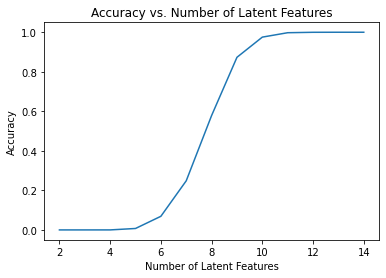

In [79]:
num_latent_feats = np.arange(2,15,1)
sum_errs = []

for i in notebook.trange(len(num_latent_feats)):
    k = num_latent_feats[i]
    # restructure with k latent features
    u_new, vt_new = personMat2[:, :k], offerMat2[:k, :]
    
    # take dot product
    person_offer_est2 = np.around(np.dot(u_new, vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.nansum(np.subtract(personOffer_mat2, person_offer_est2))
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
n_notna = (~np.isnan(personOffer_mat2)).sum()
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/(n_notna));
plt.xlabel('Number of Latent Features')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Number of Latent Features');

  0%|          | 0/13 [00:00<?, ?it/s]

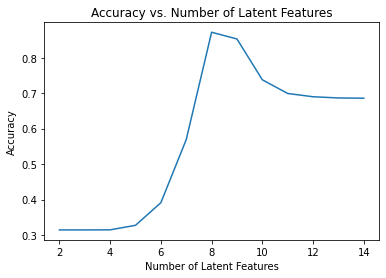

In [80]:
subset_test2 = personOffer_df_test2[personOffer_df_test2.index.isin(personOffer_df2.index)]

row_idx2 = np.where(personOffer_df2.index.isin(subset_test2.index))[0]
#col_idx = np.where(person_offer_df.columns.isin(subset_test.columns))[0]

n = len(row_idx2) # no of users in test that can be predicted from train
#m = len(col_idx) # no of features in test that can be predicted from train

num_latent_feats = np.arange(2,15,1)
sum_errs = []

for i in notebook.trange(len(num_latent_feats)):
    k = num_latent_feats[i]
    # restructure with k latent features
    u_new, vt_new = personMat2[row_idx2, :k], offerMat2[:k, :]
    
    # take dot product
    person_offer_est2 = np.around(np.dot(u_new, vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.nansum(np.subtract(subset_test2.values, person_offer_est2))
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
n_notna = (~np.isnan(subset_test2.values)).sum()
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/(n_notna));
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

In [81]:
k=8
sse_naive = 0
sse = 0
acc = []
acc_naive = []
person_list2 = np.intersect1d(personOffer_df_test2.index,personOffer_df2.index)

for i in notebook.trange(len(person_list2)):
    person = person_list2[i]
    row = np.where(personOffer_df2.index == person)[0][0]
    pred = np.dot(personMat2[row,:k], offerMat2[:k,]).astype(bool).astype(int)
    pred_naive = 0
    actual = personOffer_df_test2.loc[person].values
    error = actual-pred
    error_naive = actual - pred_naive
    
    sse += np.nansum(error**2)
    acc.append(np.nansum(np.abs(error)))
    
    acc_naive.append(np.nansum(np.abs(error_naive)))
    sse_naive += np.nansum(error_naive**2)
    
n_notna = (~np.isnan(personOffer_df_test2.values)).sum()
mse3 = sse/n_notna
accur3 = 1- sum(acc)/n_notna
mse_naive3 = sse_naive/n_notna
accur_naive3 = 1- sum(acc_naive)/n_notna
print('mse', mse3,'accuracy', accur3)
print('mse_naive', mse_naive3, 'accuracy naive', accur_naive3)

  0%|          | 0/9311 [00:00<?, ?it/s]

mse 0.314646177195978 accuracy 0.685353822804022
mse_naive 0.685353822804022 accuracy naive 0.314646177195978


In [82]:
All_results = pd.DataFrame({'Method':['naive','first FunkSVD','second FunkSVD','third FunkSVD'],
                            '# of latent features': ['-',9,9,8],
                            'MSE':[mse_naive1,mse1, mse2, mse3], 
                            'Accuracy': [accur_naive1,accur1, accur2, accur3]
    
})

All_results

,Method,# of latent features,MSE,Accuracy
0,naive,-,0.685289,0.314711
1,first FunkSVD,9,0.567580,0.432420
2,second FunkSVD,9,0.314711,0.685289
3,third FunkSVD,8,0.314646,0.685354
